In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
from PIL import Image 
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm.notebook import trange, tqdm
from plotly.subplots import make_subplots
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torchmetrics
from torch import nn
import albumentations as A
from torchmetrics.classification import Dice
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

In [3]:
try:
    import segmentation_models_pytorch as smp
except ModuleNotFoundError:
    !pip install segmentation-models-pytorch
    import segmentation_models_pytorch as smp

  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.1 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.0 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
cwd = "/kaggle/input/cvcclinicdb"

In [5]:
df = pd.read_csv(f"{cwd}/metadata.csv")
imgs_num = len(df)
print(f"Number of images - {imgs_num}")

Number of images - 612


In [6]:
def round_16(num: int):
    return 16 * math.ceil(num/16)

In [7]:
images_list = []
shape_dict = {"width": [], "height": []}
for path in tqdm(df["png_mask_path"].tolist()):
    images_list.append(path.split("/")[-1])
    mask = np.array(Image.open(f"{cwd}/{path}").convert("L"))
    width, height = mask.shape
    shape_dict["width"].append(width)
    shape_dict["height"].append(height)
shape_df = pd.DataFrame(shape_dict)
#
fig = px.scatter(shape_df, x="width", y="height", title="Shape")
fig.update_traces(marker={"size": 15})
fig.show()
#
img_shape = (shape_dict["width"][0], shape_dict["height"][0])
print(f"image shape - {img_shape}")
inputs_shape = (round_16(shape_dict["width"][0]), round_16(shape_dict["height"][0]))
print(f"inputs shape for model - {inputs_shape}")

  0%|          | 0/612 [00:00<?, ?it/s]

image shape - (288, 384)
inputs shape for model - (288, 384)


In [8]:
def id_2_images(id_: str):
    im_path = f"/kaggle/input/cvcclinicdb/PNG/Original/{id_}"
    mask_path = f"/kaggle/input/cvcclinicdb/PNG/Ground Truth/{id_}"
    im = np.array(Image.open(im_path))
    mask = np.array(Image.open(mask_path).convert("L"))
    mask = np.where(mask==0, 0, 1)
    if im.shape[0] == mask.shape[0] and im.shape[1] == mask.shape[1]:
        return im, mask
    else:
        raise Exception(f"shapes not equals, image - {im.shape}, mask - {mask.shape}")

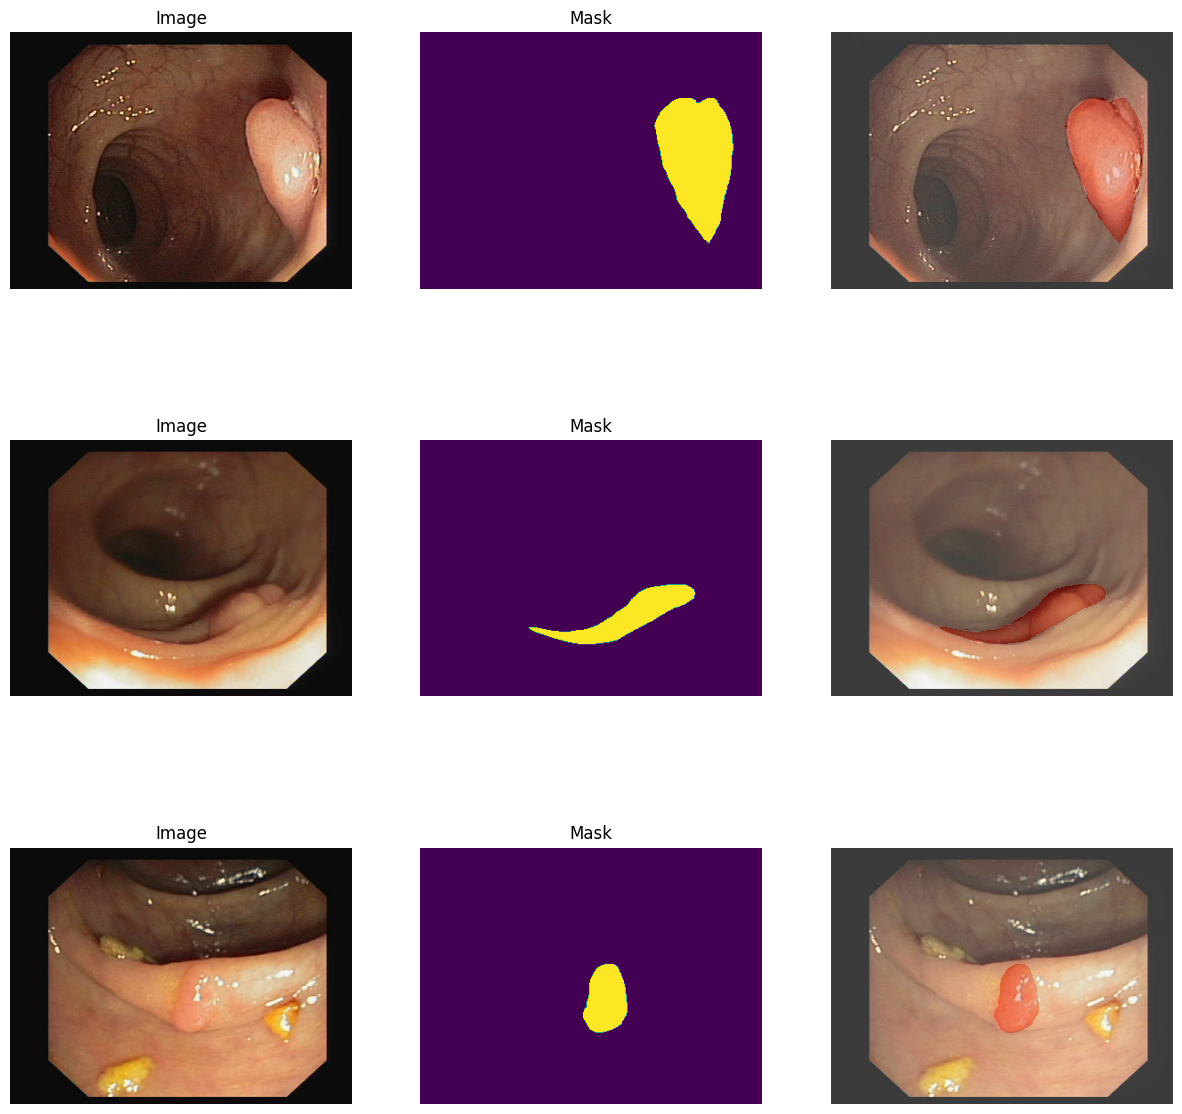

In [9]:
cols = 3
_, axs = plt.subplots(3, cols, figsize=(15, 15))
id_rand = random.choices(images_list, k=cols)
cmap = ListedColormap(["white", "red"])
for idx, id_ in enumerate(id_rand):
    im, mask = id_2_images(id_)
    axs[idx, 0].imshow(im)
    axs[idx, 0].set_title("Image")
    axs[idx, 1].imshow(mask)
    axs[idx, 1].set_title("Mask")
    axs[idx, 2].imshow(im)
    axs[idx, 2].imshow(mask, cmap=cmap, alpha=.2)
    for i in range(3):
        axs[idx, i].axis("off")

In [10]:
def add_aug_id(id_list: list, aug_num: int = 3):
    train_id = []
    for id_ in id_list:
        train_id.append(id_)
        train_id.extend([f"{id_}_aug{i+1}" for i in range(aug_num)])
    random.shuffle(train_id)
    return train_id

In [11]:
train_id, vaild_id = train_test_split(images_list, test_size=.3, random_state=42)
train_id = add_aug_id(train_id)
random.shuffle(vaild_id)

In [12]:
def print_shape(im, mask, label):
    print(f"{label} image - {im.shape}")
    print(f"{label} mask - {mask.shape}")

In [13]:
class CustomDataset(Dataset):
    def __init__(self, id_list: str):
        self.id_list = id_list
        self.transform = {}
        self.transform = A.Compose([
            A.HorizontalFlip(p=.5),
            A.VerticalFlip(p=.5),
        ])
                
    def __len__(self):
        return len(self.id_list)
    
    def __getitem__(self, index):
        id_ = self.id_list[index]
        if len(id_.split("_")) > 1:
            id_ = id_.split("_")[0]
            im, mask = id_2_images(id_)
            transformed = self.transform(image=im, mask=mask)
            im, mask = transformed["image"], transformed["mask"]
        else:
            im, mask = id_2_images(id_)
        im = im / np.max(im)
        im = im.transpose(2, 0, 1)
        mask = np.expand_dims(mask, axis=0) 
        return torch.from_numpy(im).float(), torch.from_numpy(mask).float()
            

In [14]:
train_dataset = CustomDataset(id_list=train_id)
valid_dataset = CustomDataset(id_list=vaild_id)

In [15]:
BATCH_SIZE = 2 ** 3
EPOCHS = 50 # 40
LR = 1e-6

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device - {device}")

device - cuda


In [18]:
aux_params=dict(pooling="max", activation="sigmoid", dropout=.3, classes=1)
model = smp.Unet(encoder_name="resnet34", in_channels=3, classes=1).to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 214MB/s] 


In [19]:
class TrainModel:
    def __init__(self, train_dataloader: torch.utils.data.DataLoader, valid_dataloader: torch.utils.data.DataLoader, 
                 model: torch.nn.Module, loss_fn: torch.nn.Module,
                 optimizer: torch.optim.Optimizer, accuracy: torchmetrics.classification, epochs: int, device: str):
        self.dataloader = {"train": train_dataloader, "valid": valid_dataloader,}
        self.results = {"train": {"loss": [], "dice": []},
                        "valid": {"loss": [], "dice": []}}
        self.model = model
        self.loss_fn = loss_fn
        self.opt = optimizer
        self.acc = accuracy
        self.epochs = epochs
        self.device = device
        
    def step(self, step_type: str):
        step_loss, step_acc = 0, 0
        num_batches = len(self.dataloader[step_type])
        pbar = trange(num_batches, leave=False)
        for batch, (X, y) in enumerate(self.dataloader[step_type]):
            X, y = X.to(self.device), y.to(self.device)
            y_pred = self.model(X)
            #
            loss = self.loss_fn(y_pred, y)
            step_loss += loss.item() 
            #
            acc = self.acc(y_pred, y.int())
            step_acc += acc.item()
            #
            pbar.set_description(f"{step_type.capitalize()} | loss={loss.item():.4f} | dice={acc.item():.4f} ")
            pbar.update()
            #
            if step_type == "train":
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
        pbar.container.close()
        step_loss /= len(self.dataloader[step_type])
        step_acc /= len(self.dataloader[step_type])
        #
        print(f"{step_type.capitalize()} | loss={step_loss:.4f} | dice={step_acc:.4f} ")
        #
        self.results[step_type]["loss"].append(step_loss)
        self.results[step_type]["dice"].append(step_acc)
    
    def train_step(self):
        self.model.train()
        self.step(step_type="train")
    
    def valid_step(self):
        self.model.eval()
        with torch.inference_mode():
            self.step(step_type="valid")
    
    def train(self):
        for epoch in trange(self.epochs):
            print(f"Epoch: {epoch+1}/{self.epochs}: ")
            self.train_step()
            self.valid_step()
            print("")
        return self.model
            
    def plot_results(self):
        colors = ["green", "blue"]
        fig = make_subplots(rows=2, cols=1)
        for group_ind, g in enumerate(["loss", "dice"]):
            for step_ind, s in enumerate(["train", "valid"]):
                fig.append_trace(go.Scatter(
                    x = np.arange(self.epochs),
                    y = self.results[s][g],
                    mode = "lines",
                    name = f"{s}", 
                    line = dict(color = colors[step_ind]),
                    legendgroup = f"{group_ind+1}"),
                    row = group_ind+1, col = 1)
        fig.update_layout(
            title_text = "Training results", 
            xaxis1_title = "Epochs", yaxis1_title = "Loss",
            xaxis2_title = "Epochs", yaxis2_title = "Dice", yaxis2_range=[0, 1],
            legend_tracegroupgap = 180)
        fig.show()  

In [20]:
# loss_fn = nn.BCEWithLogitsLoss().to(device)
loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
dice = Dice(ignore_index=0, average="micro").to(device)

In [21]:
session = TrainModel(train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, accuracy=dice,
                     model=model, loss_fn=loss_fn, optimizer=optimizer, epochs=EPOCHS, device=device)
model = session.train()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=1.1277 | dice=0.1811 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=1.1258 | dice=0.1701 

Epoch: 2/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=1.0540 | dice=0.2265 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=1.0308 | dice=0.2088 

Epoch: 3/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.9595 | dice=0.2789 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.9184 | dice=0.2602 

Epoch: 4/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.8771 | dice=0.3406 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.8452 | dice=0.3253 

Epoch: 5/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.8200 | dice=0.4036 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.8116 | dice=0.3880 

Epoch: 6/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.7760 | dice=0.4742 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.7646 | dice=0.4698 

Epoch: 7/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.7378 | dice=0.5397 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.7290 | dice=0.5263 

Epoch: 8/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.7051 | dice=0.5969 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.7023 | dice=0.5919 

Epoch: 9/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.6799 | dice=0.6408 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.6717 | dice=0.6234 

Epoch: 10/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.6596 | dice=0.6663 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.6526 | dice=0.6562 

Epoch: 11/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.6394 | dice=0.6977 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.6345 | dice=0.6710 

Epoch: 12/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.6218 | dice=0.7165 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.6183 | dice=0.6930 

Epoch: 13/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.6062 | dice=0.7330 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.6036 | dice=0.7113 

Epoch: 14/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.5906 | dice=0.7430 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.5846 | dice=0.7244 

Epoch: 15/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.5777 | dice=0.7543 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.5763 | dice=0.7379 

Epoch: 16/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.5647 | dice=0.7696 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.5599 | dice=0.7418 

Epoch: 17/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.5558 | dice=0.7747 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.5533 | dice=0.7568 

Epoch: 18/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.5457 | dice=0.7870 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.5492 | dice=0.7634 

Epoch: 19/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.5394 | dice=0.7867 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.5325 | dice=0.7660 

Epoch: 20/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.5299 | dice=0.7998 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.5306 | dice=0.7775 

Epoch: 21/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.5243 | dice=0.8012 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.5201 | dice=0.7822 

Epoch: 22/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/threading.py:1016: TqdmSynchronisationWarning:

Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)



Train | loss=0.5173 | dice=0.8107 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.5166 | dice=0.7875 

Epoch: 23/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.5114 | dice=0.8191 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.5109 | dice=0.7915 

Epoch: 24/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.5066 | dice=0.8222 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.5035 | dice=0.7906 

Epoch: 25/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/site-packages/tqdm/_monitor.py", line 69, in run
    instances = self.get_instances()
  File "/opt/conda/lib/python3.10/site-packages/tqdm/_monitor.py", line 49, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
  File "/opt/conda/lib/python3.10/_weakrefset.py", line 97, in copy
    return self.__class__(self)
  File "/opt/conda/lib/python3.10/_weakrefset.py", line 51, in __init__
    self.update(data)
  File "/opt/conda/lib/python3.10/_weakrefset.py", line 124, in update
    for element in other:
  File "/opt/conda/lib/python3.10/_weakrefset.py", line 65, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


Train | loss=0.5014 | dice=0.8290 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4997 | dice=0.8002 

Epoch: 26/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4969 | dice=0.8341 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4945 | dice=0.8033 

Epoch: 27/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4921 | dice=0.8398 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4928 | dice=0.8045 

Epoch: 28/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4880 | dice=0.8430 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4888 | dice=0.8140 

Epoch: 29/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4838 | dice=0.8479 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4871 | dice=0.8169 

Epoch: 30/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4798 | dice=0.8523 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4810 | dice=0.8196 

Epoch: 31/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4749 | dice=0.8596 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4748 | dice=0.8205 

Epoch: 32/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4707 | dice=0.8645 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4710 | dice=0.8206 

Epoch: 33/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4662 | dice=0.8708 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4739 | dice=0.8319 

Epoch: 34/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4634 | dice=0.8698 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4676 | dice=0.8345 

Epoch: 35/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4586 | dice=0.8765 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4664 | dice=0.8384 

Epoch: 36/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4552 | dice=0.8804 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4662 | dice=0.8415 

Epoch: 37/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4525 | dice=0.8779 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4551 | dice=0.8401 

Epoch: 38/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4484 | dice=0.8833 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4565 | dice=0.8443 

Epoch: 39/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4440 | dice=0.8882 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4496 | dice=0.8400 

Epoch: 40/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4406 | dice=0.8894 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4434 | dice=0.8435 

Epoch: 41/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4362 | dice=0.8937 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4396 | dice=0.8480 

Epoch: 42/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4331 | dice=0.8937 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4342 | dice=0.8414 

Epoch: 43/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4300 | dice=0.8934 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4347 | dice=0.8497 

Epoch: 44/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4262 | dice=0.8981 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4309 | dice=0.8509 

Epoch: 45/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4217 | dice=0.9039 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4292 | dice=0.8505 

Epoch: 46/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4183 | dice=0.9037 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4292 | dice=0.8601 

Epoch: 47/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4134 | dice=0.9044 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4221 | dice=0.8624 

Epoch: 48/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4081 | dice=0.9098 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4154 | dice=0.8591 

Epoch: 49/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4048 | dice=0.9082 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4141 | dice=0.8658 

Epoch: 50/50: 


  0%|          | 0/214 [00:00<?, ?it/s]

Train | loss=0.4007 | dice=0.9118 


  0%|          | 0/23 [00:00<?, ?it/s]

Valid | loss=0.4092 | dice=0.8610 



In [22]:
def plot_model_performance(nums: int):
    title_list = ["Image", "Ground truth", "Perdiction"]
    _, axs = plt.subplots(nums, 3, figsize=(15,15)) 
    id_list = random.choices(vaild_id, k=3)
    for row, id_ in enumerate(id_list):
        im, mask = id_2_images(id_)
        #
        im_tensor = torch.from_numpy(im.transpose(2, 0, 1) / im.max()).unsqueeze(0).float()
        mask_tensor = torch.from_numpy(np.expand_dims(mask, axis=0)).float()
        #
        with torch.inference_mode():
            pred = model(im_tensor.to(device))
        pred = torch.where(pred > .5, 1, 0)
        d = dice(pred.to(device), mask_tensor.int().to(device)).item()
        #
        mask_pred = pred.cpu().numpy()[0, 0, ...]
        axs[row, 0].imshow(im)
        axs[row, 1].imshow(mask)
        axs[row, 2].imshow(mask_pred)
        for i in range(3):
            if i < 2:
                axs[row, i].set_title(title_list[i])
            else:
                axs[row, i].set_title(f"{title_list[i]} | dice={100 * d:.2f}%")
            axs[row, i].axis("off")
            

In [23]:
session.plot_results()

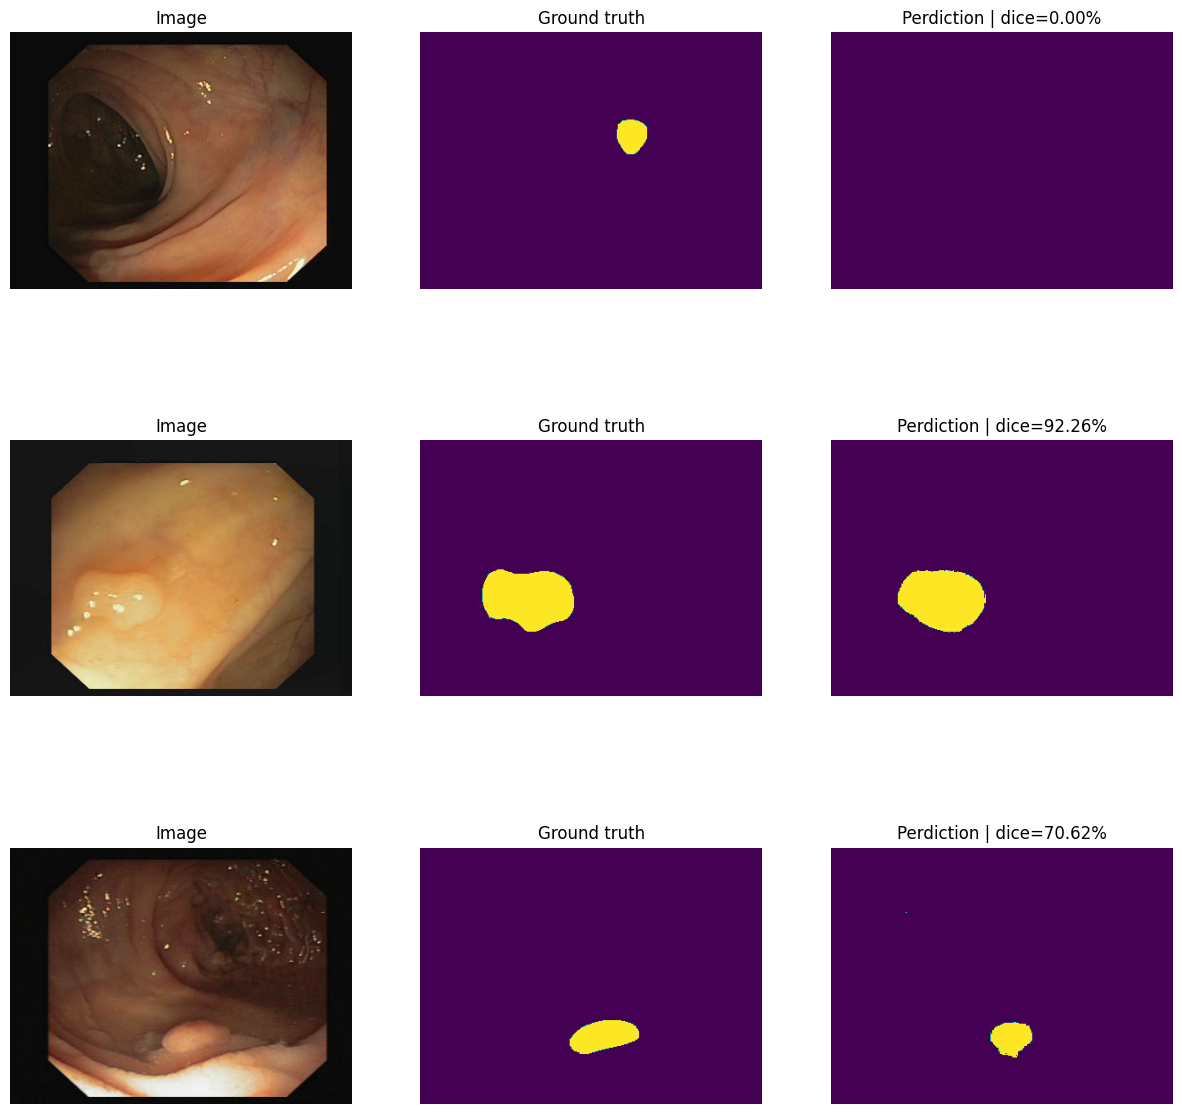

In [24]:
plot_model_performance(nums=3)